# Задача предсказания спроса на онлайн-рекламу Avito

Это задача, в которой нужно предсказать спрос на онлайн-рекламу товаров, продающихся на [Avito](https://www.kaggle.com/competitions/avito-demand-prediction/overview). Входные данные для задачи являются мультимодальными: они содержат и табличные данные, и тексты, и изображения. Однако, в данной работе будем полагаться только на табличную информацию, характеризующую рекламу.

Задача соревнования заключается в следующем: необходимо спрогнозировать спрос на онлайн-рекламу на основании следующих характеристик: категория, заголовок, изображение, контекст (географически, где он был размещен) и исторический спрос на аналогичные объявления в аналогичных контекстах.

Данные обучения содержат следующие функции:

* `item_id` - идентификатор объявления.
* `user_id` - идентификатор пользователя.
* `region` - рекламный регион.
* `city` - рекламный город.
* `parent_category_name` - категория объявления высшего уровня, классифицированная по модели рекламы Avito.
* `category_name` - категория мелкозернистых объявлений в соответствии с моделью объявлений Avito.
* `param_1` - необязательный параметр из рекламной модели Avito.
* `param_2` - необязательный параметр из рекламной модели Avito.
* `param_3` - необязательный параметр из рекламной модели Avito.
* `title` - заголовок объявления.
* `description` - описание объявления.
* `price` - цена объявления.
* `item_seq_number` - порядковый номер объявления для пользователя.
* `activation_date` - дата объявления была размещена.
* `user_type` - тип пользователя.
* `image` - идентификационный код изображения. Связывает с файлом jpg в train_jpg. Не каждое объявление имеет изображение.
* `image_top_1` - код классификации Avito для изображения.
* `deal_probability` - целевая переменная. Это вероятность того, что реклама действительно что-то продала. Значение этой функции может быть любым с плавающей точкой от нуля до единицы.

#### Данные
[train.csv](https://www.dropbox.com/s/qlguchrzn6yutd3/train.csv)

[test.csv](https://www.dropbox.com/s/jhwrj5qffmqxg6i/test.csv)

# Анализ данных

In [1]:
# общее
import pandas as pd
import os
import datetime
import numpy as np

# модели
import catboost

#метрики
from sklearn.metrics import mean_squared_error

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# утилиты
from sklearn.model_selection import train_test_split


In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_test_item_id = data_test["item_id"]

In [3]:
data_test["test"] = 1
data_train["test"] = 0
data_global = pd.concat([data_test,data_train])

In [4]:
data_global.head(5)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,test,deal_probability
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0,1,NaN
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN,1,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0,1,NaN
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN,1,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0,1,NaN


In [5]:
data_global.shape

(2011862, 19)

Посмотрим на типы наших данных

In [6]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 1503423
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   item_id               object 
 1   user_id               object 
 2   region                object 
 3   city                  object 
 4   parent_category_name  object 
 5   category_name         object 
 6   param_1               object 
 7   param_2               object 
 8   param_3               object 
 9   title                 object 
 10  description           object 
 11  price                 float64
 12  item_seq_number       int64  
 13  activation_date       object 
 14  user_type             object 
 15  image                 object 
 16  image_top_1           float64
 17  test                  int64  
 18  deal_probability      float64
dtypes: float64(3), int64(2), object(14)
memory usage: 307.0+ MB


Посмотрим на кол-во уникальных значений в кадом столбце 

In [7]:
data_global.nunique()

item_id                 2011862
user_id                 1009909
region                       28
city                       1752
parent_category_name          9
category_name                47
param_1                     371
param_2                     277
param_3                    1276
title                   1022203
description             1793972
price                     20760
item_seq_number           33947
activation_date              30
user_type                     3
image                   1856665
image_top_1                3063
test                          2
deal_probability          18407
dtype: int64

Все обьекты в колонке item_id содержат уникальные значения, дропним его

In [8]:
data_global = data_global.drop(columns="item_id")

## Изменения признаков и их обработка

В данном фрагменте ноутбука, постараемся изучить наши признаки и передлать их более информативные. Постаремся следовать следующему плану:
1. Преобразуем дату в 3 колонки (день, месяц, день недели)
2. Преобразовать param_*, image на флаги "присутствует/отсутсвует"
3. Аггрегировать по пользователю - количество объявлений
4. Пропуски в данных заменить на моду/медиану
5. Добавить различные фичи
6. Преобразовать object в category

### 1. Преобразование даты

Цель: преобразовать дату в 3 колонки (день, месяц, день недели)

In [9]:
data_global.activation_date.value_counts()

2017-03-20    115190
2017-03-27    114863
2017-03-19    114416
2017-03-26    113513
2017-03-28    112885
2017-03-21    110535
2017-03-22    109813
2017-03-15    108615
2017-03-23    106544
2017-03-16    106168
2017-03-17     98773
2017-03-18     97554
2017-03-24     97351
2017-03-25     97104
2017-04-12     81824
2017-04-18     81114
2017-04-17     80191
2017-04-13     77176
2017-04-14     70366
2017-04-16     58909
2017-04-15     58793
2017-03-29        87
2017-04-19        64
2017-04-02         3
2017-04-01         3
2017-03-30         3
2017-04-03         2
2017-04-20         1
2017-04-07         1
2017-03-31         1
Name: activation_date, dtype: int64

В данных используется только один год, поэтому он на не нужен. Формируем колонки "day" "month". 

In [10]:
data_global['activation_date'] = data_global['activation_date'].str.replace('-', '.')
data_global['day'] = data_global['activation_date'].str.split('.').str[2].astype("int64")
data_global['month'] = data_global['activation_date'].str.split('.').str[1].astype("int64")
data_global['year'] = data_global['activation_date'].str.split('.').str[0].astype("int64")

С помощью библиотеки datatime получаем день недели (day_of_week)

In [11]:
data_global['date_datetime'] = data_global.apply(lambda x: datetime.datetime(year=x['year'], month=x['month'], day=x['day']), axis=1)
data_global['day_of_week'] = data_global['date_datetime'].apply(lambda x: x.weekday()).astype("int64")

Удаляем временные колонки

In [12]:
data_global = data_global.drop(columns=['activation_date','date_datetime','year','month'])

### 2.Преобразование параметров в флаги

Цель : преобразовать param_*, image на флаги "присутствует/отсутсвует"

In [13]:
name_cols = ["param_2","param_3","image_top_1"]

In [14]:
for i,name in enumerate(name_cols):
    print("===========================================================")
    print("Кол-во None до обработки в колонке ", name, ": ", data_global[name].isna().sum())
    unique_object = data_global[name].unique()
    data_global[name+"_new"] = data_global[name].fillna('No')
    data_global[name+"_new"] = data_global[name+"_new"].replace(unique_object, 'Yes')
    print("Кол-во None после обработки в колонке ", name, ": ", data_global[name+"_new"].isna().sum())
    print("Кол-во уникальных значений до и после обработки ", name, ": ", unique_object.size," | ",data_global[name+"_new"].unique().size )


Кол-во None до обработки в колонке  param_2 :  887771
Кол-во None после обработки в колонке  param_2 :  0
Кол-во уникальных значений до и после обработки  param_2 :  278  |  2
Кол-во None до обработки в колонке  param_3 :  1168896
Кол-во None после обработки в колонке  param_3 :  0
Кол-во уникальных значений до и после обработки  param_3 :  1277  |  2
Кол-во None до обработки в колонке  image_top_1 :  155197
Кол-во None после обработки в колонке  image_top_1 :  0
Кол-во уникальных значений до и после обработки  image_top_1 :  3064  |  2


In [15]:
data_global['image'] = data_global['image'].fillna("none").astype("string")
data_global['image_new'] = data_global['image'].apply(lambda x: "No" if x =="none" else "Yes")

In [16]:
data_global = data_global.drop(columns=['image'])

### 3. Агрегировать по пользователю

Цель: составить кол-во объявлений у каждого пользователя и минимальную/максимальную разницу в днях между объявлениями

Посчитаем количество обьявлений у пользователя 

In [17]:
counts = data_global['user_id'].value_counts()

In [18]:
data_global['count_ads'] = data_global['user_id'].map(counts).astype("int64")

### 4. Редактируем пропуски

Посмотрим на пропуски в данных используя тепловую карту

<AxesSubplot:>

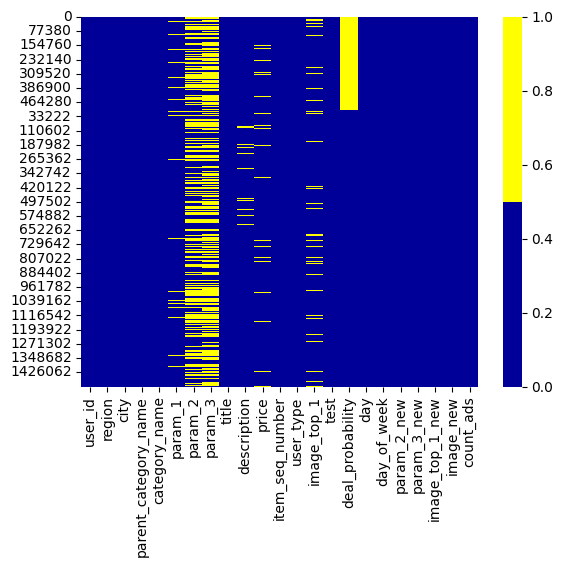

In [19]:
cols = data_global.columns[:]
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099','#ffff00'] 
sns.heatmap(data_global[cols].isnull(), cmap=sns.color_palette(colours))

Посмотрим на точные цифры пропущенных значений

In [20]:
data_global.isna().sum()

user_id                       0
region                        0
city                          0
parent_category_name          0
category_name                 0
param_1                   84486
param_2                  887771
param_3                 1168896
title                         0
description              116276
price                    115947
item_seq_number               0
user_type                     0
image_top_1              155197
test                          0
deal_probability         508438
day                           0
day_of_week                   0
param_2_new                   0
param_3_new                   0
image_top_1_new               0
image_new                     0
count_ads                     0
dtype: int64

У параметра "price" заполним пропуски по среднее значение по категории товара

In [21]:
data_global["mean_price_category"] = data_global.groupby("category_name")["price"].transform("mean")
data_global["price"] = data_global.price.fillna(data_global["mean_price_category"]).astype("float64")

Заменим пропуски у param* на "No_have",а у image_top_1 на самое популярное значение

In [22]:
name_cols_mode = ["param_1","param_2","param_3"]

In [23]:
for name in name_cols_mode:
    data_global[name] = data_global[name].fillna("No_have")
data_global["image_top_1"] = data_global["image_top_1"].fillna(-1)
    

In [24]:
data_global["image_top_1"] = data_global["image_top_1"].astype("int64")

Колонка "description" нам понадобится в 6 пункте, пока оставим его.
Колонка "deal_probability" является таргетом, т.к. мы обьеденили датасеты тут показаны пропуски data_test

### 5.Фичи 

Цель: создать различные дополнительные колонки для улучшения показателей модели

У колонки title/description расчитаем длину текста

In [25]:
name_cols = ["title","description"]

In [26]:
for i,name in enumerate(name_cols):
    data_global[name] = data_global[name].fillna("").astype("string")
    data_global[name+ '_length'] = data_global[name].apply(lambda x: len(x))

Добавим новую колонку больше или меньше цена товара, чем среднее по категории

In [27]:
data_global["price_more_or_less_average"] = data_global.apply(lambda x: "more" if(x["price"] > x["mean_price_category"]) else "less", axis = 1)

Добавим еще несколько фич

In [28]:
data_global["mean_price_region"] = data_global.groupby("region")["price"].transform("mean")

In [29]:
data_global["mean_price_city"] = data_global.groupby("city")["price"].transform("mean")

In [30]:
data_global["mean_price_user"] = data_global.groupby("user_id")["price"].transform("mean")

In [31]:
data_global["mean_price_parent_category_name"] = data_global.groupby("parent_category_name")["price"].transform("mean")

In [32]:
data_global["avg_price_region_category_name"] = data_global.groupby(["category_name","region"])["price"].transform("mean")

In [33]:
data_global = data_global.drop(columns=["title","description","user_id"])

### 6. Приведение типов

Цель: преобразовать все object в category

In [34]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 1503423
Data columns (total 29 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   region                           object 
 1   city                             object 
 2   parent_category_name             object 
 3   category_name                    object 
 4   param_1                          object 
 5   param_2                          object 
 6   param_3                          object 
 7   price                            float64
 8   item_seq_number                  int64  
 9   user_type                        object 
 10  image_top_1                      int64  
 11  test                             int64  
 12  deal_probability                 float64
 13  day                              int64  
 14  day_of_week                      int64  
 15  param_2_new                      object 
 16  param_3_new                      object 
 17  image_to

In [35]:
name_colums_category = ['region', 'city', 'parent_category_name', 'category_name', 'user_type',
                     'param_2_new','param_3_new', 'image_new',"image_top_1_new",
                     'price_more_or_less_average','image_top_1',"param_1","param_2","param_3"]
for name in name_colums_category:
       data_global[name] = data_global[name].astype('category')

In [36]:
data_global["image_top_1"] = data_global["image_top_1"].astype('int64')
data_global["price"] = data_global["price"].astype('int64')

### Финальные данные

In [37]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011862 entries, 0 to 1503423
Data columns (total 29 columns):
 #   Column                           Dtype   
---  ------                           -----   
 0   region                           category
 1   city                             category
 2   parent_category_name             category
 3   category_name                    category
 4   param_1                          category
 5   param_2                          category
 6   param_3                          category
 7   price                            int64   
 8   item_seq_number                  int64   
 9   user_type                        category
 10  image_top_1                      int64   
 11  test                             int64   
 12  deal_probability                 float64 
 13  day                              int64   
 14  day_of_week                      int64   
 15  param_2_new                      category
 16  param_3_new                      cat

In [38]:
data_global.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,...,count_ads,mean_price_category,title_length,description_length,price_more_or_less_average,mean_price_region,mean_price_city,mean_price_user,mean_price_parent_category_name,avg_price_region_category_name
0,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,8266,66,Private,...,2,8266.079390,15,12,less,184275.320701,1.734309e+05,294133.039695,7447.174198,971.330275
1,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,No_have,No_have,3000,4,Private,...,1,7771.094424,16,88,less,148570.589201,1.352024e+06,3000.000000,16614.430035,8039.246779
2,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,No_have,No_have,15000,15,Private,...,3,7659.265144,3,132,more,138419.257361,2.168464e+05,13733.333333,16811.282027,8413.027018
3,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,No_have,4500,70,Private,...,4,7315.126184,17,93,less,154455.855197,1.475962e+05,9625.000000,17165.552320,4464.705799
4,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,No_have,No_have,4900,15,Private,...,1,4007.415670,17,60,more,207136.991422,1.930074e+05,4900.000000,7447.174198,2657.923659


In [39]:
data_test = data_global[data_global.test == 1]
data_train = data_global[data_global.test == 0]

data_test = data_test.drop(columns = ['test','deal_probability'])
data_train_Y = data_train['deal_probability']
data_train_X = data_train.drop(columns = ['test','deal_probability'])

# Обучение модели

## Catboost

Составим список категориальных колонок

In [40]:
category_columns = list(data_train_X.select_dtypes("category").columns)
category_columns.append('image_top_1')
category_columns.append("price")
category_columns.append("item_seq_number")

In [41]:
boosting_model = catboost.CatBoostRegressor(eval_metric = "RMSE",
                                             early_stopping_rounds=25,# если значение не меняется 25 итераций, то переходим к след параметру
                                             iterations=1000,
                                             cat_features=[data_train_X.columns.get_loc(c) for c in category_columns],
                                             task_type="GPU",
                                             devices='0:2'
                                             ).fit(data_train_X,data_train_Y)

Learning rate set to 0.10532
0:	learn: 0.2557312	total: 340ms	remaining: 5m 39s
1:	learn: 0.2521994	total: 755ms	remaining: 6m 16s
2:	learn: 0.2492575	total: 1.1s	remaining: 6m 6s
3:	learn: 0.2468022	total: 1.51s	remaining: 6m 16s
4:	learn: 0.2446293	total: 1.96s	remaining: 6m 30s
5:	learn: 0.2428570	total: 2.41s	remaining: 6m 39s
6:	learn: 0.2414410	total: 2.82s	remaining: 6m 40s
7:	learn: 0.2402261	total: 3.13s	remaining: 6m 28s
8:	learn: 0.2391414	total: 3.52s	remaining: 6m 27s
9:	learn: 0.2382775	total: 3.86s	remaining: 6m 21s
10:	learn: 0.2375065	total: 4.28s	remaining: 6m 25s
11:	learn: 0.2368443	total: 4.73s	remaining: 6m 29s
12:	learn: 0.2362476	total: 5.11s	remaining: 6m 28s
13:	learn: 0.2356389	total: 5.58s	remaining: 6m 33s
14:	learn: 0.2351447	total: 5.93s	remaining: 6m 29s
15:	learn: 0.2346938	total: 6.42s	remaining: 6m 34s
16:	learn: 0.2343333	total: 6.77s	remaining: 6m 31s
17:	learn: 0.2340751	total: 7.22s	remaining: 6m 34s
18:	learn: 0.2338289	total: 7.72s	remaining: 6m

Посмотрим на важность признаков библиотеки CatBoost

In [42]:
boosting_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,param_1,17.935758
1,image_top_1,12.958719
2,mean_price_user,9.029872
3,price,8.443406
4,param_2,7.455792
5,count_ads,6.982943
6,parent_category_name,6.597891
7,user_type,3.792012
8,category_name,3.547759
9,description_length,3.160106


Сохраним результаты предсказания на teste

In [43]:
predicted_values = list(boosting_model.predict(data_test))
for index, item in enumerate(predicted_values):
    if(item<0):
        predicted_values[index] = 0
predicted_values= np.array(predicted_values)

my_submission = pd.DataFrame()
my_submission['item_id'] = data_test_item_id
my_submission['deal_probability'] = predicted_values
my_submission.to_csv('./avito_submissionRegressor.csv', index=False)

# Shap и сравнение библиотек

In [44]:
import shap

C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train_X, data_train_Y, test_size=0.2, random_state=42)

Посмотрим на важность признаков библиотеки Shap

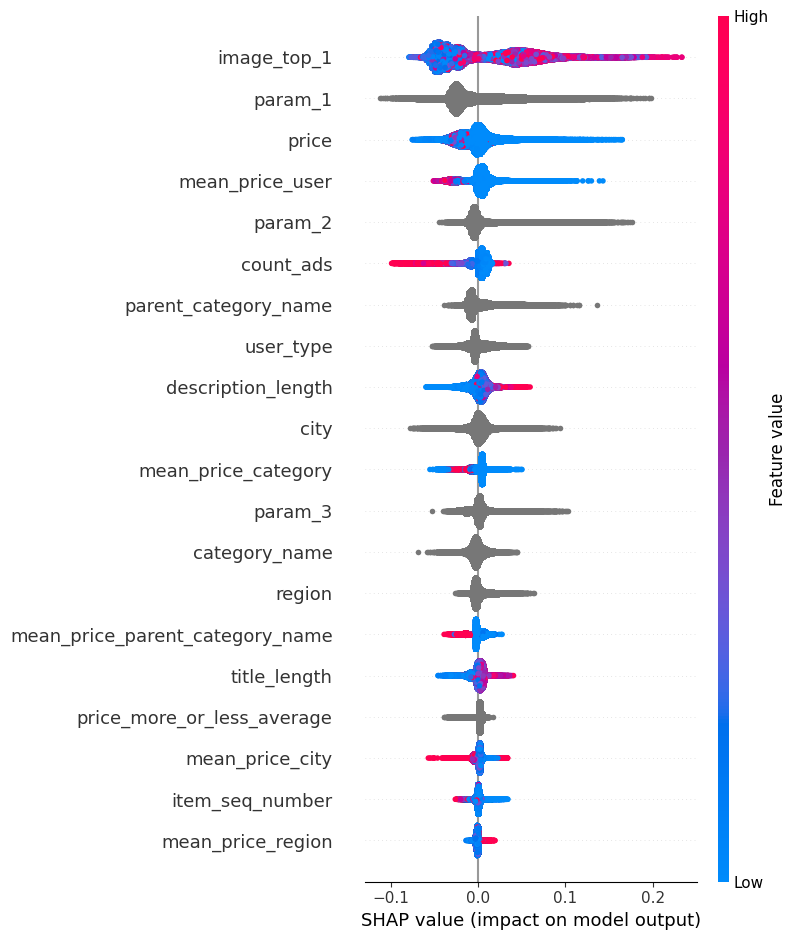

In [46]:
explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)

Посмотрим на график библиотеки shep
* `image_top_1` - Чем больше код классификации Авито, тем лучше продается это объявление и чем ниже код, тем хуже.
* `price` - По распределению точек сложно сказать однозначно, но точна видна тенденция чем ниже цена, тем лучше продается объявление.
* `mean_price_user` - У пользователя средняя цена по объявлениям низкая, то объявления продается лучше.
* `count_ads` - Если пользователь выкладывает редко объявления, то объявление продается лучше.
* `description_length` - Чем больше длина описания продукта, тем лучше проедется.
* `mean_price_category` - Чем выше цена мелкозернистых объявлений, тем хуже продаются.
* `mean_price_parent_category_name` - Чем выше категория объявления высшего уровня, тем хуже продается по сравнению с низкой категорией.
* `title_length` - Чем больше название объявления, тем лучше оно продается.
* `mean_price_city` - Чем выше средняя цена по городу, тем хуже продается объявление.
* `item_seq_number` - Чем больше номер объявления у пользователя, тем хуже оно продается.
* `mean_price_region` - Если в регионе средняя цена объявления высокая, то лучше продается объявление.

Сравнение важности признака в библиотеке CatBoost и shap, что распределение значимости признака происходит примерно одинаково и не сильно отличается. 

# Kaggle - 0.22825

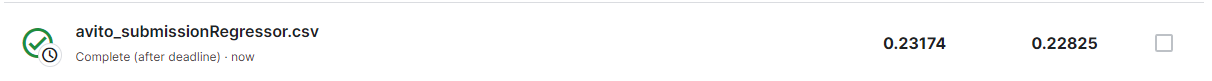

# Отчет

В ходе работы были проанализированы данные, на которых была построена модель.

Для этого были выполнены следующие действия:
1) Дата была преобразована в 3 колонки: день, месяц, день недели. Это поможет добавить дополнительные данные для модели.
2) Параметры param_* и изображение image были преобразованы в флаги "присутствует/отсутствует", что способствует увеличению данных.
3) Данные были агрегированы по пользователям и были сгруппированные различные показатели.
4) Пропуски в данных были заменены на моду или медиану в зависимости от типа данных.
5) Были добавлены различные фичи.
6) Тип данных object был преобразован в категориальный.

После этого была обучена модель CatBoost, результаты которой были проанализированы с помощью библиотеки shap.
